# Q1
__ See Assignment2_practical.pdf __ 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import random
import pickle
import gzip

from utilities import linear_ini
from utilities import adjust_lr
from utilities import prediction
from utilities import N_prediction
from utilities import L2_weights_norm
from utilities import set_parameters


In [2]:

import pickle

with open('../datasets/mnist.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train, valid, test = u.load()

train_x, train_y = train
valid_x, valid_y = valid
test_x, test_y = test

train_x = train_x.reshape(50000,28,28)
valid_x = valid_x.reshape(10000,28,28)
test_x = test_x.reshape(10000,28,28)

train_data = torch.FloatTensor(train_x)
train_data_ = Variable(train_data.view(-1,784))
train_labels = torch.FloatTensor(train_y).long()
train_labels_ = Variable(train_labels.view(-1))

valid_data = torch.FloatTensor(valid_x)
valid_data_ = Variable(valid_data.view(-1,784))
valid_labels = torch.FloatTensor(valid_y).long()
valid_labels_ = Variable(valid_labels.view(-1))

test_data = torch.FloatTensor(test_x)
test_data_ = Variable(valid_data.view(-1,784))
test_labels = torch.FloatTensor(test_y).long()
test_labels_ = Variable(valid_labels.view(-1))

batch_size = 64
train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data,train_labels), batch_size=batch_size, shuffle=True)
valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=False)
test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data,test_labels), batch_size=batch_size, shuffle=False)



In [3]:
class MLPLinear(nn.Module):
	def __init__(self, dimensions, dp, cuda):
		super(MLPLinear, self).__init__()
		self.h0 = int(dimensions[0])
		self.h1 = int(dimensions[1])
		self.h2 = int(dimensions[2])       

		self.fc1 = torch.nn.Linear(self.h0, self.h1)
		self.fc2 = torch.nn.Linear(self.h1, self.h2)
		self.fc2_drop = nn.Dropout(p=dp)
		self.relu = nn.ReLU()
		self.criterion = nn.CrossEntropyLoss()
		self.cuda = cuda

		if cuda: 
			self.fc1.cuda()
			self.fc2.cuda()
			self.fc2_drop.cuda()
			self.relu.cuda()
			self.criterion.cuda()

	def initialization(self,method):
		self.fc1 = linear_ini(self.fc1,method)
		self.fc2 = linear_ini(self.fc2,method)

	def input_shape(self,x,y):
		x = (x.view(-1,784))
		y = (y)  
		if self.cuda : 
			x = Variable(x.cuda())
			y = Variable(y.cuda())
		else: 
			x = Variable(x)
			y = Variable(y)
		return x,y

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		out = self.fc2_drop(out)
		return  out

# Q1 (a)

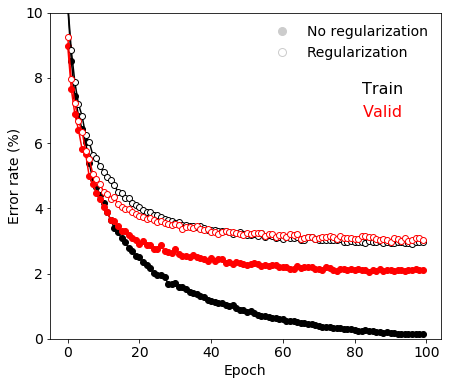

In [4]:
fig, (ax1) = plt.subplots(1,figsize=(7,6))

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_No_Regularization_v2', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)

ax1.plot([60],[-1],'o',markersize=8,color=[0.8,0.8,0.8])
ax1.plot([60],[-1],'o',markersize=8,color=[0.8,0.8,0.8],markerfacecolor = 'w')
ax1.plot(100 - acc_train,'-ko',markersize=6)
ax1.plot(100 - acc_valid,'-ro',markersize=6)

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_Regularization_v2', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)

ax1.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor = 'w')
ax1.plot(100 - acc_valid,'-ro',markersize=6, markerfacecolor = 'w')

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)

ax1.set_ylim([0,10])
for i, ax in enumerate([ax1]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
ax1.text(0.8*(xmax - xmin) + xmin, 0.75*(ymax-ymin) + ymin,'Train', fontsize=16,color='k')        
ax1.text(0.8*(xmax - xmin) + xmin, 0.68*(ymax-ymin) + ymin,'Valid', fontsize=16,color='r')        

legend = ax1.legend(['No regularization','Regularization'],loc='upper right',fontsize=14,frameon=False)
# plt.suptitle('Effect of the weight decay', fontsize=20, y=1.05)
# plt.tight_layout()

plt.show()        
fig.savefig('Figures/Q1/Q1_weight_decay_no_regularization.pdf') #, bbox_inches='tight'


In [5]:
with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_No_Regularization', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm  = pickle.load(f)    

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_Regularization', 'rb') as f:
    acc_train_r, acc_valid_r, error_train_r, error_valid_r, L2norm_r  = pickle.load(f)

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_No_Regularization_v2', 'rb') as f:    
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)
    
with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_Regularization_v2', 'rb') as f:    
    acc_train_r, acc_valid_r, error_train_r, error_valid_r, L2norm_r, acc_test_r, error_test_r  = pickle.load(f)    


print('Optimized conditions - with and without regularization')
print('------------------------------------------------------')
print('   ')



print('No regularization, Train ==> {:.0f} errors @ {} epochs'.format(np.min(error_train), np.argmin(error_train)))
print('   Regularization, Train ==> {:.0f} errors @ {} epochs'.format(np.min(error_train_r), np.argmin(error_train_r)))
print('   ')
print('No regularization, Train ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_train), np.argmin(error_train)))
print('   Regularization, Train ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_train_r), np.argmin(error_train_r)))
print('   ')
print('   ')



print('No regularization, Valid ==> {:.0f} errors @ {} epochs'.format(np.min(error_valid), np.argmin(error_valid)))
print('   Regularization, Valid ==> {:.0f} errors @ {} epochs'.format(np.min(error_valid_r), np.argmin(error_valid_r)))
print('   ')
print('No regularization, Valid ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_valid), np.argmin(error_valid)))
print('   Regularization, Valid ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_valid_r), np.argmin(error_valid_r)))
print('   ')
print('   ')

print('No regularization, Test ==> {:.0f} errors @ {} epochs'.format(np.min(error_test), np.argmin(error_test)))
print('   Regularization, Test ==> {:.0f} errors @ {} epochs'.format(np.min(error_test_r), np.argmin(error_test_r)))
print('   ')
print('No regularization, Test ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_test), np.argmin(error_test)))
print('   Regularization, Test ==> {:.2f}% errors @ {} epochs'.format(np.min(100 - acc_test_r), np.argmin(error_test_r)))






Optimized conditions - with and without regularization
------------------------------------------------------
   
No regularization, Train ==> 66 errors @ 99 epochs
   Regularization, Train ==> 1455 errors @ 96 epochs
   
No regularization, Train ==> 0.13% errors @ 99 epochs
   Regularization, Train ==> 2.91% errors @ 96 epochs
   
   
No regularization, Valid ==> 206 errors @ 84 epochs
   Regularization, Valid ==> 298 errors @ 90 epochs
   
No regularization, Valid ==> 2.06% errors @ 84 epochs
   Regularization, Valid ==> 2.98% errors @ 90 epochs
   
   
No regularization, Test ==> 197 errors @ 0 epochs
   Regularization, Test ==> 327 errors @ 0 epochs
   
No regularization, Test ==> 1.97% errors @ 0 epochs
   Regularization, Test ==> 3.27% errors @ 0 epochs


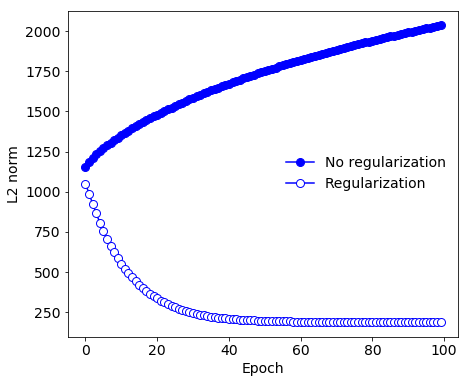

In [6]:
fig, (ax) = plt.subplots(1,figsize=(7,6))

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_No_Regularization_v2', 'rb') as f:
    _,_,_,_, L2norm, _, _  = pickle.load(f)

ax.plot(L2norm,'-ob',markersize=8)

with open('SaveData/Q1/MNIST_Error_Accuracy_L2norm_Regularization_v2', 'rb') as f:
    _,_,_,_, L2norm, _, _  = pickle.load(f)

ax.plot(L2norm,'-ob',markersize=8, markerfacecolor='w')

####################################################################################
####################################################################################

ax.set_ylabel('L2 norm',fontsize=14)
ax.set_xlabel('Epoch',fontsize=14)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
# ax.text(0.7*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,'$\lambda = 2.5$', fontsize=16 ,color='k')        

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)        

legend = ax.legend(['No regularization','Regularization'],loc='center right',fontsize=14,frameon=False)

plt.show()        
    
fig.savefig('Figures/Q1/Q1_L2Norm.pdf')


# Q1 (b)

In [7]:
with open('SaveData/Q1/MNIST_Error_Accuracy_Dropout', 'rb') as f:
    acc_test_i, error_test_i, acc_test_N, error_test_N, acc_test_N_2, error_test_N_2  = pickle.load(f)

# _N : averaging BEFORE softmax    
# _N_2 : averaging AFTER softmax

print('The test accuracy for dropout = 0.5 ')
print('------------------------------------')

print('Test Accuracy = %.2f'%acc_test_i)
    
N = np.array([1,2,3,4,5,8,10,15,20,30,40,50,60,70,80,90,100])
print(N.shape)
print(acc_test_N)
print(acc_test_N_2)


The test accuracy for dropout = 0.5 
------------------------------------
Test Accuracy = 58.84
(17,)
[ 57.87  81.02  91.04  94.65  95.9   96.46  96.73  96.66  96.85  96.89
  96.9   96.87  96.87  96.83  96.88  96.9   96.96]
[ 57.82  81.34  91.22  94.82  96.01  96.6   96.77  96.88  96.84  96.83
  96.9   96.84  96.89  96.89  96.89  96.87  96.89]


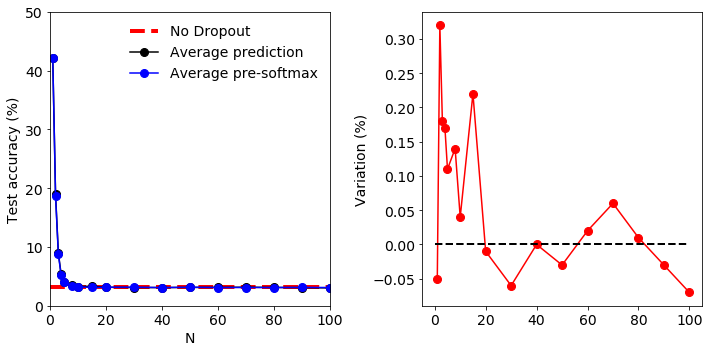

In [8]:

with open('SaveData/Q1/MNIST_Error_Accuracy_NO_Dropout', 'rb') as f:
    acc_test_i, error_test_i = pickle.load(f)


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))    

ax1.plot([0,100], [100-acc_test_i,100-acc_test_i] ,'--r', linewidth = 4)
ax1.plot(N, 100 - acc_test_N ,'-ok',markersize=8)
ax1.plot(N, 100 - acc_test_N_2,'-ob',markersize=8)


ax2.plot(N, acc_test_N_2 - acc_test_N,'-or',markersize=8)
ax2.plot([0,100], [0,0] ,'--k', linewidth = 2)
####################################################################################
####################################################################################

ax1.set_ylabel('Test accuracy (%)',fontsize=14)
ax2.set_ylabel('Variation (%)',fontsize=14)
ax1.set_xlabel('N',fontsize=14)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
ax1.set_xlim([0,100])
ax1.set_ylim([0,50])
# ax.set_ylim([50,100])
# ax.text(0.7*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,'$\lambda = 2.5$', fontsize=16 ,color='k')        

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(14)

legend = ax1.legend(['No Dropout','Average prediction','Average pre-softmax'],loc='upper right',fontsize=14,frameon=False)
plt.tight_layout()


plt.show()

fig.savefig('Figures/Q1/Q1_drop_out_N.pdf')


In [9]:
cuda = False
model = MLPLinear([784, 800, 10], 0.5, cuda)
model.load_state_dict(torch.load('SaveData/Q1/model_Q1b.pth', map_location=lambda storage, loc: storage))
set_parameters(model,'fc2.weight',0.5)


print('Prediction with dropout: ')
print('   ')
acc, error = prediction(train_batch,model)
print('Train accuracy = {:.2f}%'.format(100 - acc))

acc, error = prediction(valid_batch,model)
print('Valid accuracy = {:.2f}%'.format(100 -acc))

acc, error = prediction(test_batch,model)
print('Test accuracy = {:.2f}%'.format(100 -acc))

Prediction with dropout: 
   
Train accuracy = 41.20%
Valid accuracy = 41.39%
Test accuracy = 40.75%


# Q1 (c)

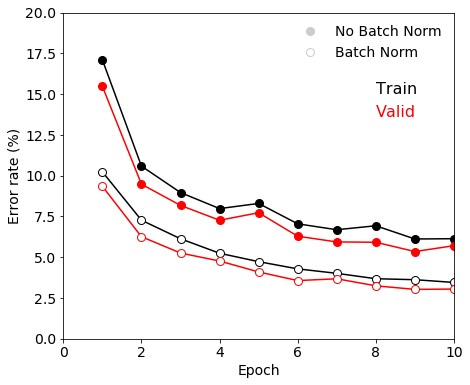

In [10]:
fig, (ax1) = plt.subplots(1,figsize=(7,6))

with open('SaveData/Q1/MNIST_Error_Accuracy_Convolution', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)

ax1.plot([0],[-1],'o',markersize=8,color=[0.8,0.8,0.8])
ax1.plot([0],[-1],'o',markersize=8,color=[0.8,0.8,0.8],markerfacecolor = 'w')
ax1.plot(range(1,11),100 - acc_train,'-ko',markersize=8)
ax1.plot(range(1,11),100 - acc_valid,'-ro',markersize=8)

with open('SaveData/Q1/MNIST_Error_Accuracy_Convolution_BatchNorm', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test_bn, error_test  = pickle.load(f)

ax1.plot(range(1,11), 100 - acc_train,'-ko',markersize=8, markerfacecolor='w')
ax1.plot(range(1,11), 100 - acc_valid,'-ro',markersize=8, markerfacecolor='w')

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_xlim((0,10))
for i, ax in enumerate([ax1]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

ax1.set_ylim([0,20])
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
ax1.text(0.8*(xmax - xmin) + xmin, 0.75*(ymax-ymin) + ymin,'Train', fontsize=16,color='k')        
ax1.text(0.8*(xmax - xmin) + xmin, 0.68*(ymax-ymin) + ymin,'Valid', fontsize=16,color='r')        

legend = ax1.legend(['No Batch Norm','Batch Norm'],loc='upper right',fontsize=14,frameon=False)
# plt.suptitle('Effect of the weight decay', fontsize=20, y=1.05)
# plt.tight_layout()

plt.show()        
fig.savefig('Figures/Q1/Q1_convolution_BatchNorm_ON_OFF.pdf') #, bbox_inches='tight'



In [11]:
with open('SaveData/Q1/MNIST_Error_Accuracy_Convolution', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)

print('No batch norm, train error = {:.2f}%'.format(100 - acc_train[-1]))
print('No batch norm, valid error = {:.2f}%'.format(100 - acc_valid[-1]))
print('No batch norm, test error = {:.2f}%'.format(100 - acc_test))

with open('SaveData/Q1/MNIST_Error_Accuracy_Convolution_BatchNorm', 'rb') as f:
    acc_train, acc_valid, error_train, error_valid, L2norm, acc_test, error_test  = pickle.load(f)

print('   Batch norm, train error = {:.2f}%'.format(100 - acc_train[-1]))
print('   Batch norm, valid error = {:.2f}%'.format(100 - acc_valid[-1]))
print('   Batch norm, test error = {:.2f}%'.format(100 - acc_test))

No batch norm, train error = 6.14%
No batch norm, valid error = 5.71%
No batch norm, test error = 5.96%
   Batch norm, train error = 3.46%
   Batch norm, valid error = 3.05%
   Batch norm, test error = 3.01%
